In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score


import xgboost as xgb
import joblib


import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [ ]:

try:
    train_df = pd.read_csv('data/train.csv')
    test_df = pd.read_csv('data/test.csv')
    print("✅ Datasets loaded successfully")
    print(f"Training set shape: {train_df.shape}")
    print(f"Test set shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"❌ Error loading datasets: {e}")
    print("Please ensure 'train.csv' and 'test.csv' are in the working directory")

✅ Datasets loaded successfully
Training set shape: (10990, 17)
Test set shape: (2000, 16)


In [ ]:

print("=== TRAINING DATASET OVERVIEW ===")
print(f"Shape: {train_df.shape}")
print(f"Features: {list(train_df.columns)}")
print("\n=== DATA TYPES ===")
print(train_df.dtypes)
print("\n=== FIRST 5 ROWS ===")
print(train_df.head())


print("\n=== TEST DATASET OVERVIEW ===")
print(f"Shape: {test_df.shape}")
print(f"Features: {list(test_df.columns)}")

=== TRAINING DATASET OVERVIEW ===
Shape: (10990, 17)
Features: ['Customer_ID', 'Age', 'Gender', 'Location', 'Subscription_Type', 'Account_Age_Months', 'Monthly_Spending', 'Total_Usage_Hours', 'Support_Calls', 'Late_Payments', 'Streaming_Usage', 'Discount_Used', 'Satisfaction_Score', 'Last_Interaction_Type', 'Complaint_Tickets', 'Promo_Opted_In', 'Churn']

=== DATA TYPES ===
Customer_ID                int64
Age                        int64
Gender                    object
Location                  object
Subscription_Type         object
Account_Age_Months         int64
Monthly_Spending         float64
Total_Usage_Hours          int64
Support_Calls              int64
Late_Payments              int64
Streaming_Usage            int64
Discount_Used              int64
Satisfaction_Score         int64
Last_Interaction_Type     object
Complaint_Tickets          int64
Promo_Opted_In             int64
Churn                      int64
dtype: object

=== FIRST 5 ROWS ===
   Customer_ID  Age  Gende

In [4]:
print("=== MISSING VALUES ANALYSIS ===")


print("\nTraining Dataset:")
train_missing = train_df.isnull().sum()
train_missing_pct = (train_missing / len(train_df)) * 100
missing_train = pd.DataFrame({
    'Missing_Count': train_missing,
    'Missing_Percentage': train_missing_pct
}).sort_values('Missing_Count', ascending=False)
print(missing_train[missing_train['Missing_Count'] > 0])


print("\nTest Dataset:")
test_missing = test_df.isnull().sum()
test_missing_pct = (test_missing / len(test_df)) * 100
missing_test = pd.DataFrame({
    'Missing_Count': test_missing,
    'Missing_Percentage': test_missing_pct
}).sort_values('Missing_Count', ascending=False)
print(missing_test[missing_test['Missing_Count'] > 0])


print("\n=== STATISTICAL SUMMARY ===")
print(train_df.describe())

=== MISSING VALUES ANALYSIS ===

Training Dataset:
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []

Test Dataset:
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []

=== STATISTICAL SUMMARY ===
        Customer_ID           Age  Account_Age_Months  Monthly_Spending  \
count  10990.000000  10990.000000        10990.000000      10990.000000   
mean    5012.510737     43.580073           30.073430        105.216138   
std     2300.328804     14.842667           16.939298         54.158877   
min     1001.000000     18.000000            1.000000         10.090000   
25%     3049.250000     31.000000           15.000000         59.300000   
50%     5022.000000     44.000000           30.000000        105.580000   
75%     7007.750000     56.000000           44.000000        150.775000   
max     9000.000000     69.000000           59.000000        199.940000   

       Total_Usage_Hours  Support_Calls  Late_Payments  Streaming_Usage  \
count       

=== TARGET VARIABLE ANALYSIS ===
Churn Distribution:
Retained (Class 0): 5495 customers (50.00%)
Churned (Class 1): 5495 customers (50.00%)


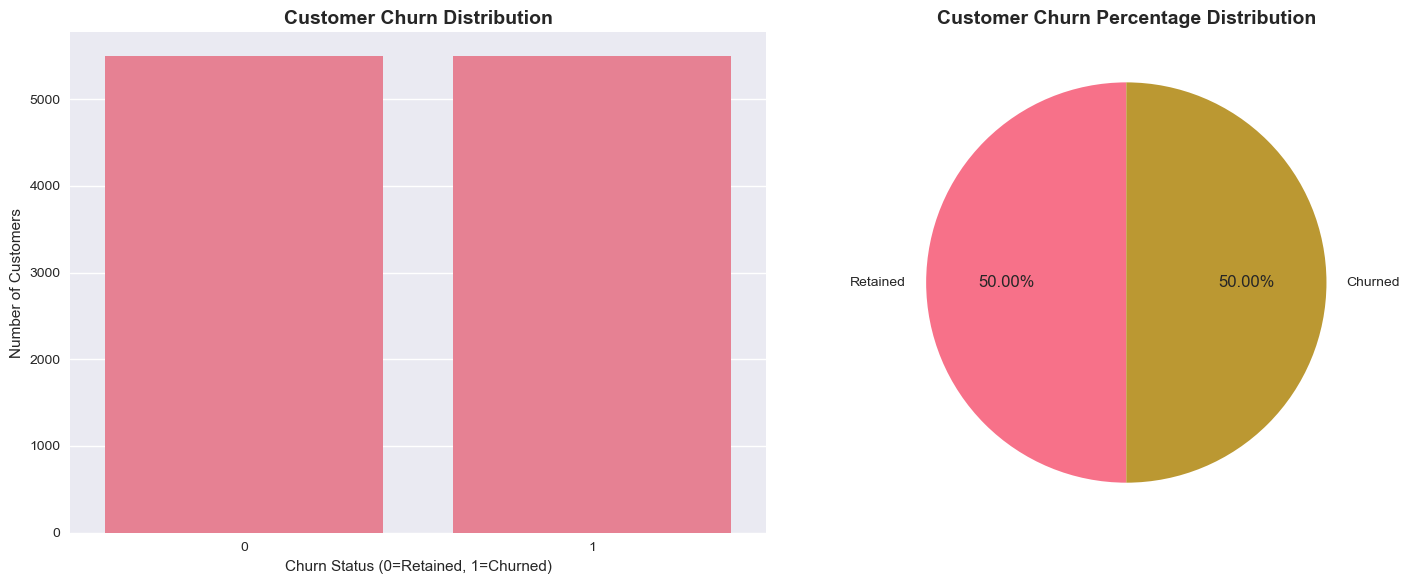


Class Imbalance Ratio: 1.00:1 (Retained:Churned)


In [5]:
print("=== TARGET VARIABLE ANALYSIS ===")
churn_counts = train_df['Churn'].value_counts()
churn_percentages = train_df['Churn'].value_counts(normalize=True) * 100

print("Churn Distribution:")
for value, count in churn_counts.items():
    label = "Churned" if value == 1 else "Retained"
    print(f"{label} (Class {value}): {count} customers ({churn_percentages[value]:.2f}%)")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=train_df, x='Churn', ax=ax1)
ax1.set_title('Customer Churn Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Churn Status (0=Retained, 1=Churned)')
ax1.set_ylabel('Number of Customers')

ax2.pie(churn_counts.values, labels=['Retained', 'Churned'], autopct='%1.2f%%', startangle=90)
ax2.set_title('Customer Churn Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nClass Imbalance Ratio: {churn_counts[0]/churn_counts[1]:.2f}:1 (Retained:Churned)")

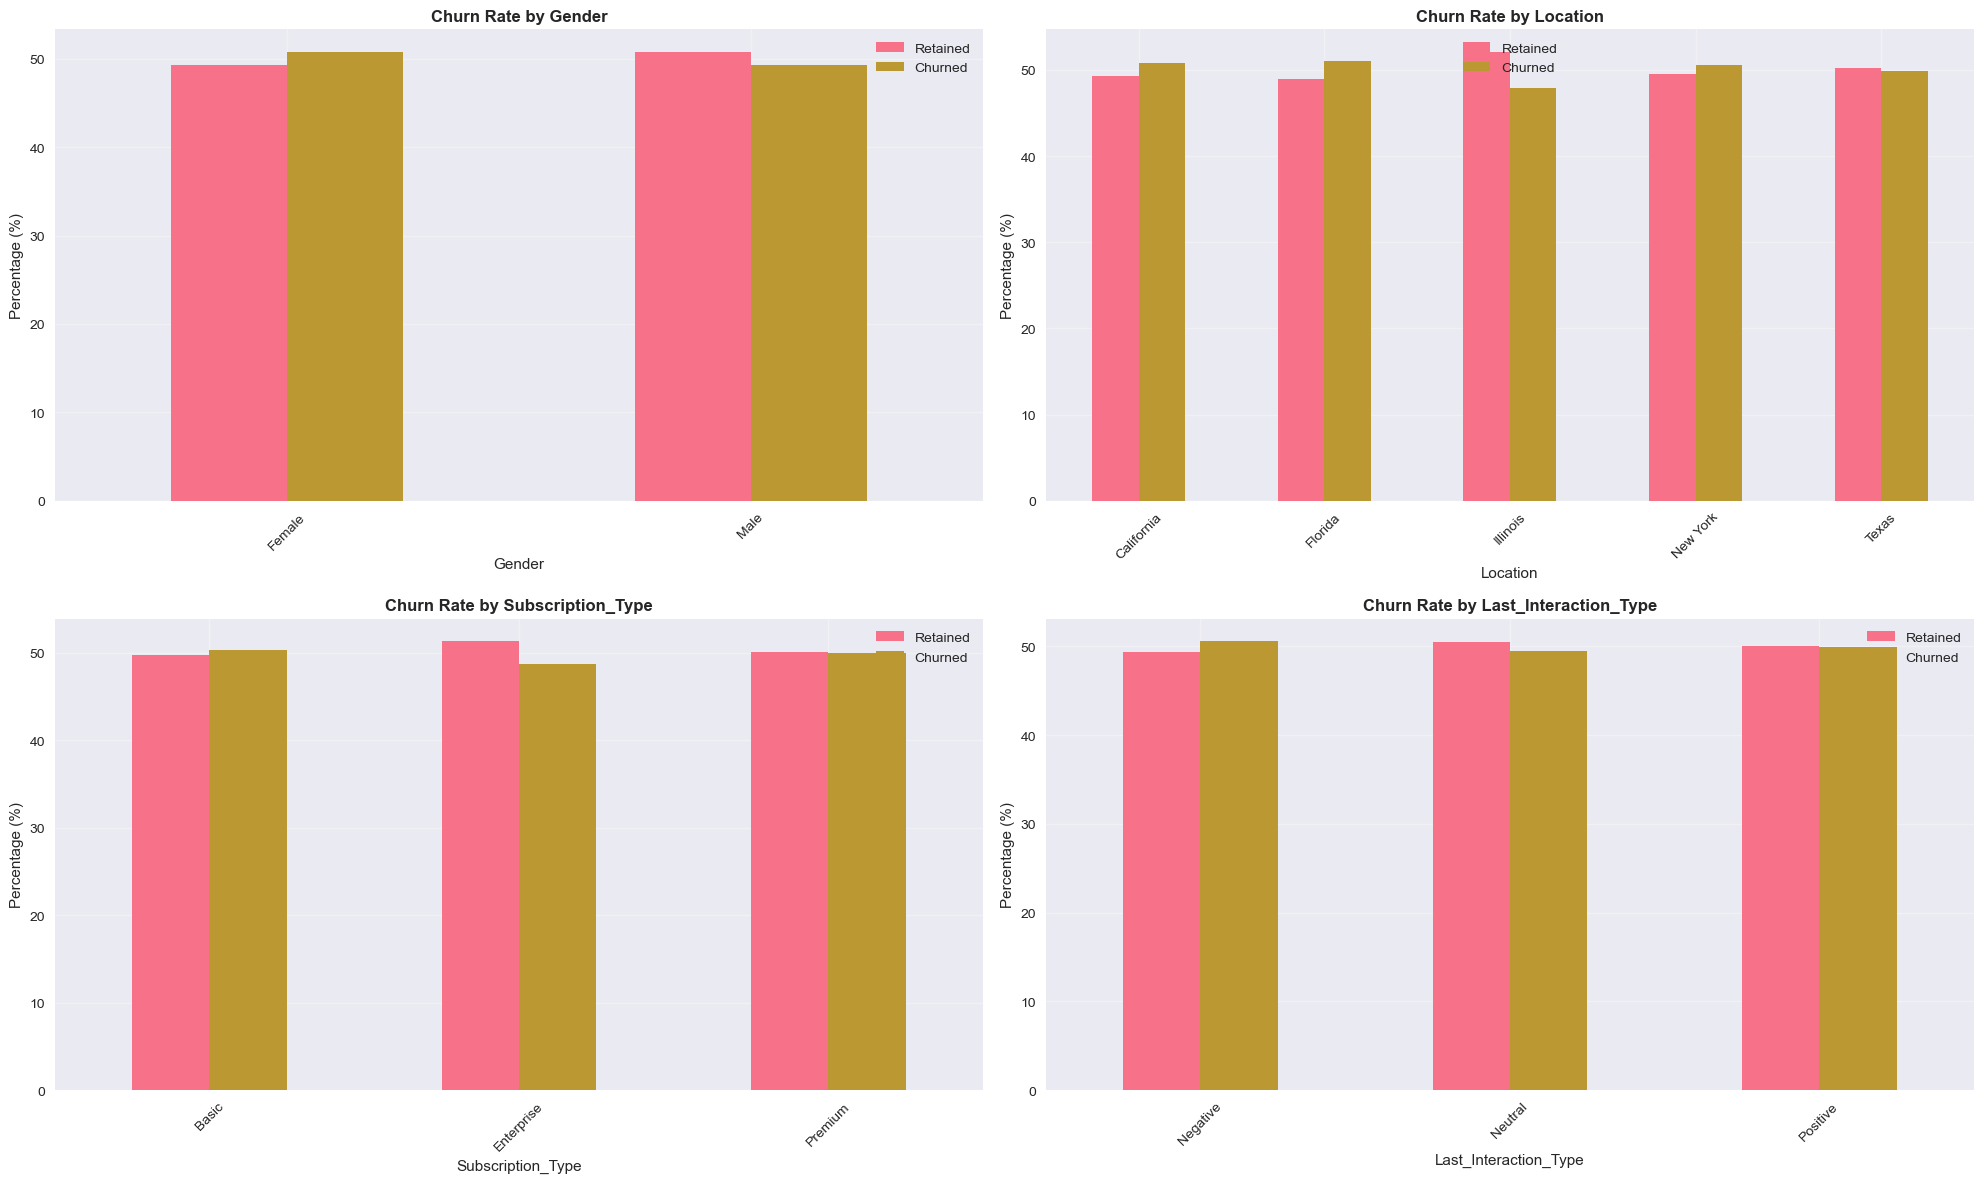

In [6]:
categorical_features = ['Gender', 'Location', 'Subscription_Type', 'Last_Interaction_Type']

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.ravel()

for idx, feature in enumerate(categorical_features):
    churn_by_category = pd.crosstab(train_df[feature], train_df['Churn'], normalize='index') * 100
    churn_by_category.plot(kind='bar', ax=axes[idx], rot=45)
    axes[idx].set_title(f'Churn Rate by {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Percentage (%)')
    axes[idx].legend(['Retained', 'Churned'])
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

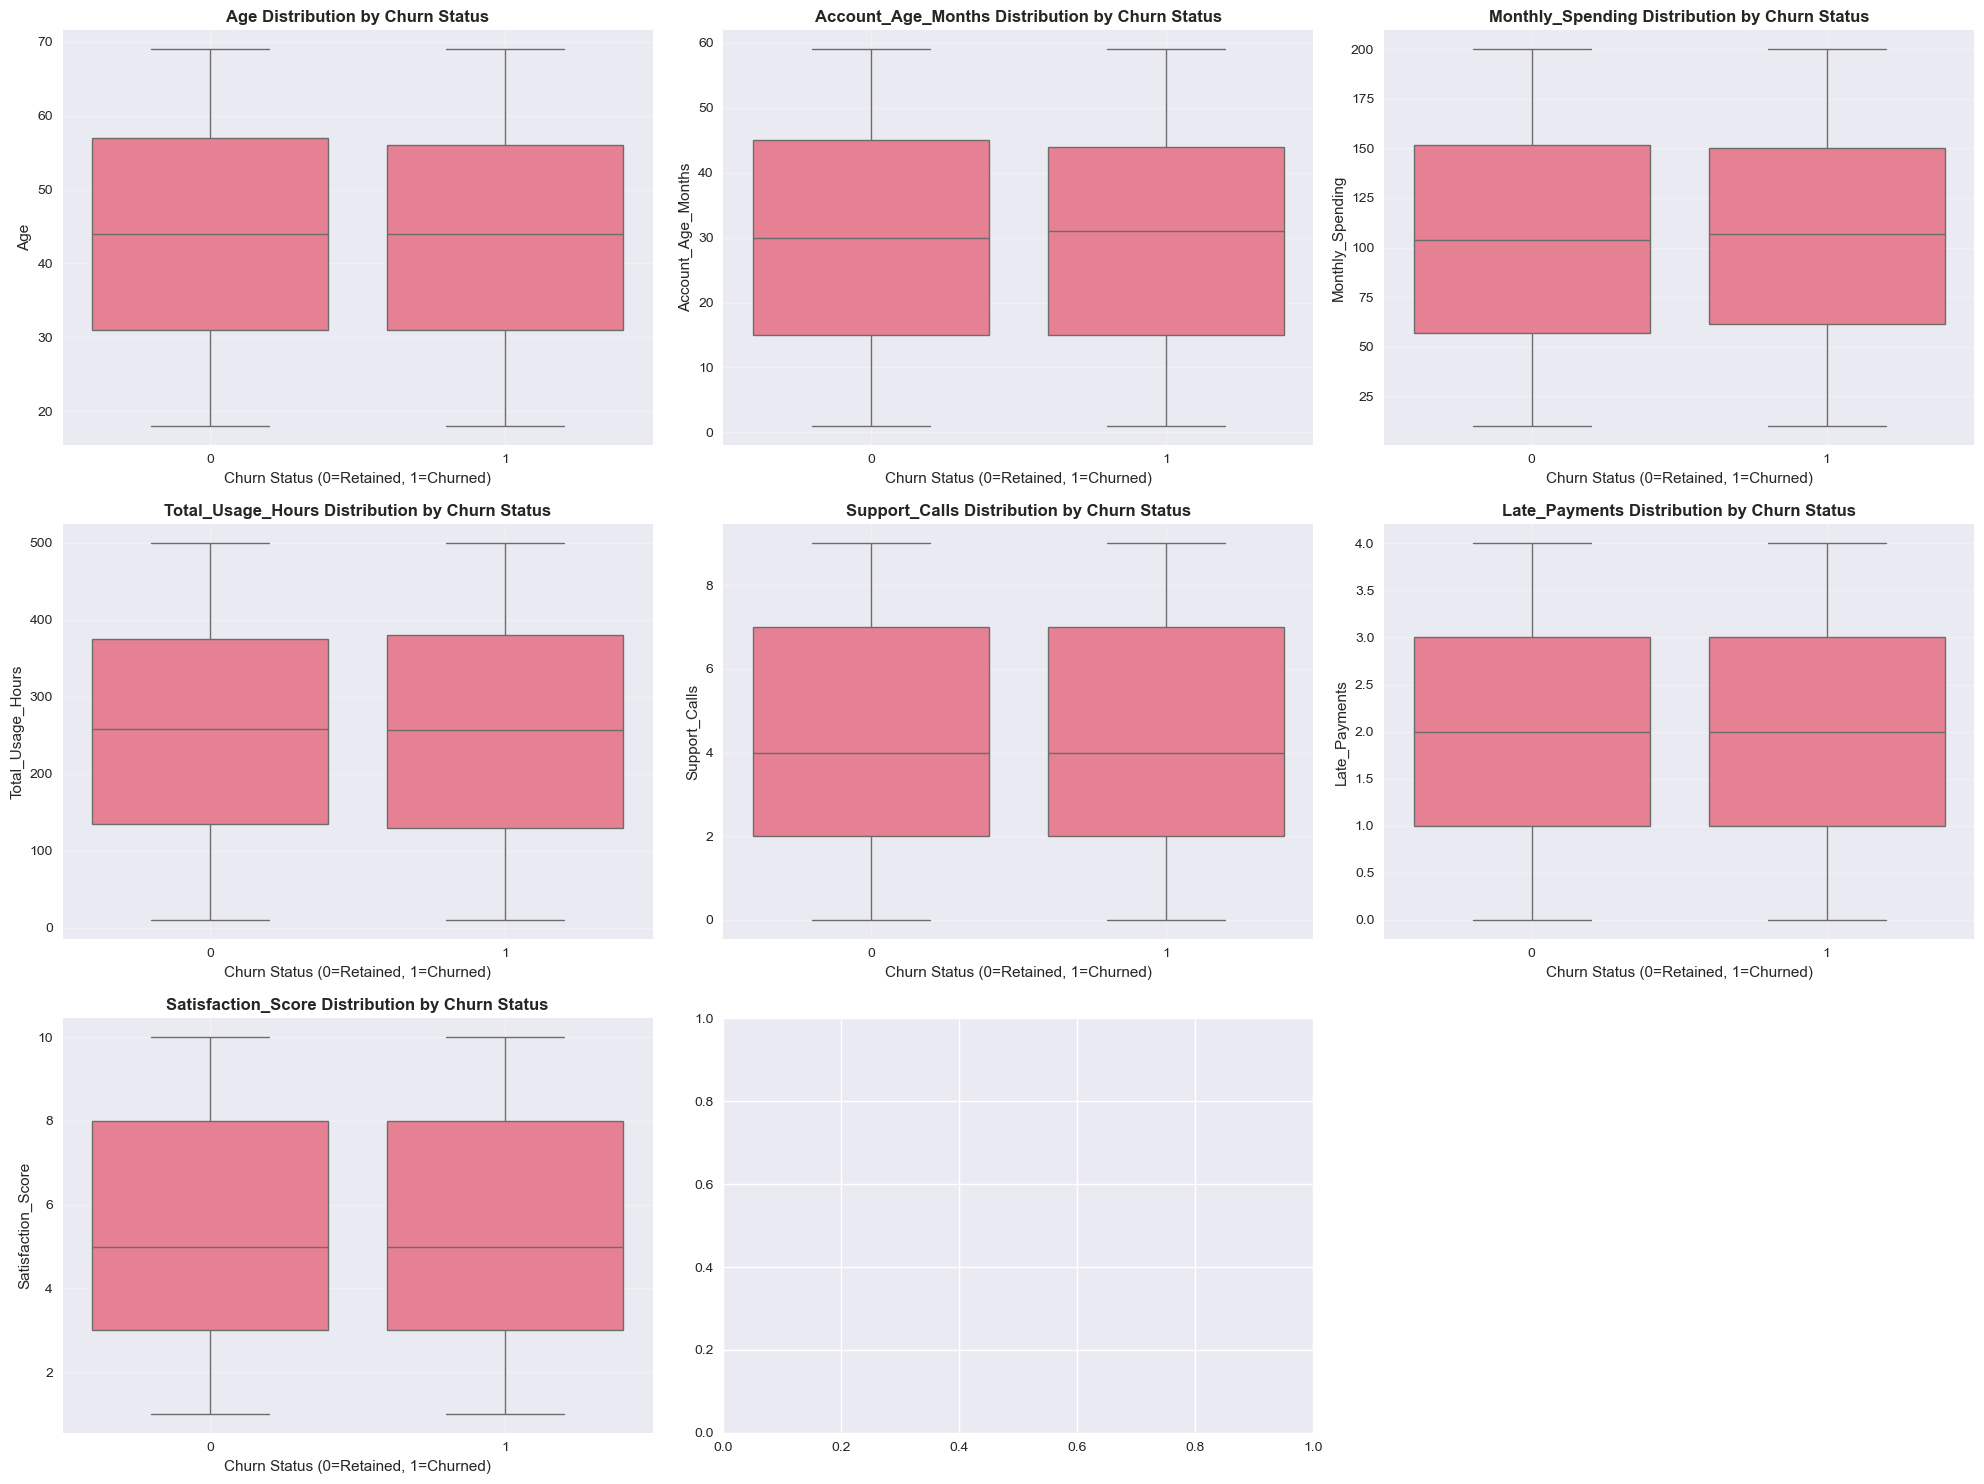

In [7]:
numerical_features = ['Age', 'Account_Age_Months', 'Monthly_Spending', 'Total_Usage_Hours', 
                     'Support_Calls', 'Late_Payments', 'Satisfaction_Score']

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    if idx < len(axes):
        sns.boxplot(data=train_df, x='Churn', y=feature, ax=axes[idx])
        axes[idx].set_title(f'{feature} Distribution by Churn Status', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Churn Status (0=Retained, 1=Churned)')
        axes[idx].grid(True, alpha=0.3)

if len(numerical_features) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

=== CORRELATION ANALYSIS ===


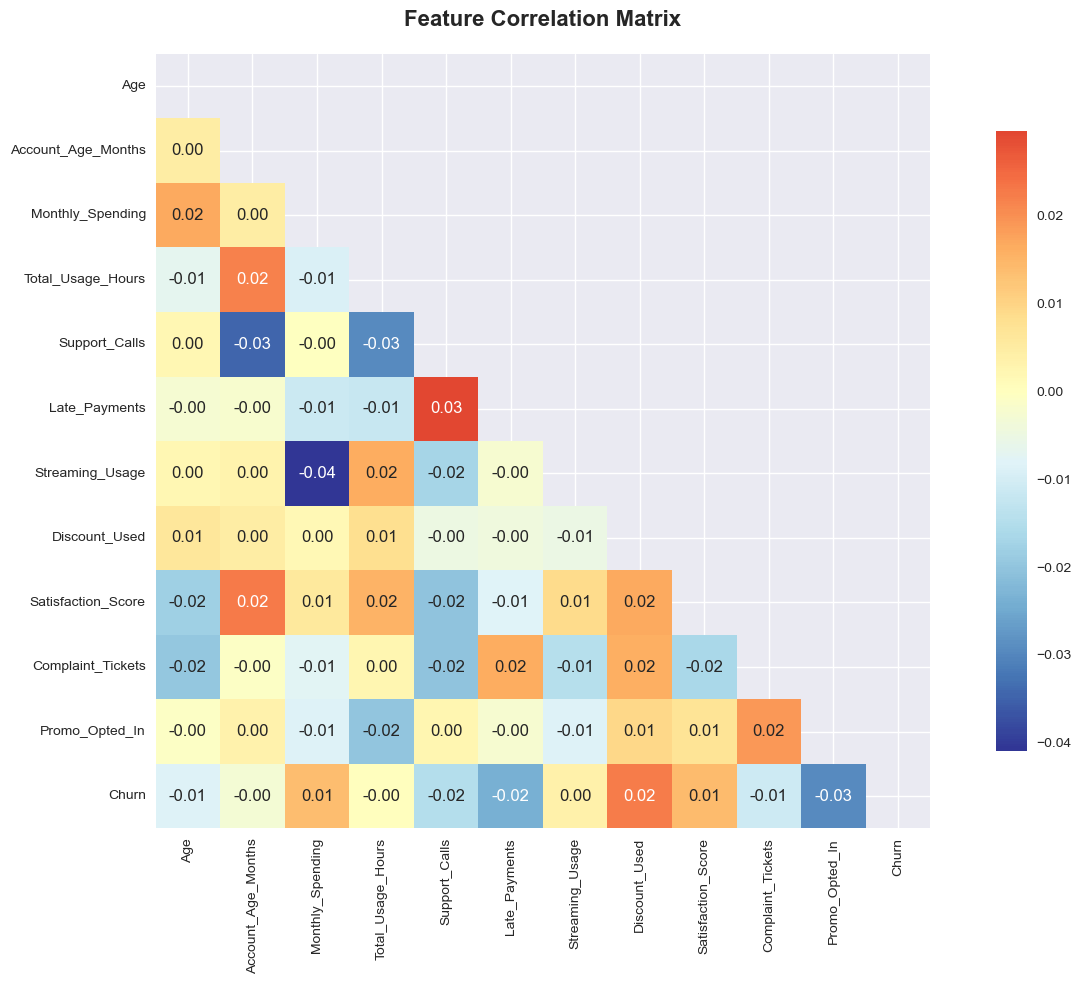

No highly correlated feature pairs found (|r| > 0.7)


In [8]:
print("=== CORRELATION ANALYSIS ===")

numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'Customer_ID' in numerical_cols:
    numerical_cols.remove('Customer_ID')

correlation_matrix = train_df[numerical_cols].corr()


plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Feature_1': correlation_matrix.columns[i],
                'Feature_2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("High Correlation Pairs (|r| > 0.7):")
    for pair in high_corr_pairs:
        print(f"{pair['Feature_1']} ↔ {pair['Feature_2']}: {pair['Correlation']:.3f}")
else:
    print("No highly correlated feature pairs found (|r| > 0.7)")

In [9]:
def preprocess_data(df, is_training=True, scaler=None, encoders=None):
    """
    Comprehensive data preprocessing pipeline
    """
    df_processed = df.copy()
    

    if 'Customer_ID' in df_processed.columns:
        customer_ids = df_processed['Customer_ID'].copy()
        df_processed = df_processed.drop('Customer_ID', axis=1)
    else:
        customer_ids = None
    
   
    if is_training and 'Churn' in df_processed.columns:
        y = df_processed['Churn'].copy()
        df_processed = df_processed.drop('Churn', axis=1)
    else:
        y = None
    
   
    categorical_features = ['Gender', 'Location', 'Subscription_Type', 'Last_Interaction_Type']
    
    if is_training:
        encoders = {}
        for feature in categorical_features:
            if feature in df_processed.columns:
                encoders[feature] = LabelEncoder()
                df_processed[feature] = encoders[feature].fit_transform(df_processed[feature])
    else:
        for feature in categorical_features:
            if feature in df_processed.columns and encoders and feature in encoders:
                unique_values = set(df_processed[feature].unique())
                known_values = set(encoders[feature].classes_)
                unseen_values = unique_values - known_values
                
                if unseen_values:
                    print(f"Warning: Unseen categories in {feature}: {unseen_values}")
                    most_frequent = encoders[feature].classes_[0]
                    df_processed[feature] = df_processed[feature].replace(list(unseen_values), most_frequent)
                
                df_processed[feature] = encoders[feature].transform(df_processed[feature])
    
  
    if is_training:
        scaler = StandardScaler()
        df_processed = pd.DataFrame(
            scaler.fit_transform(df_processed), 
            columns=df_processed.columns,
            index=df_processed.index
        )
    else:
        df_processed = pd.DataFrame(
            scaler.transform(df_processed), 
            columns=df_processed.columns,
            index=df_processed.index
        )
    
    return df_processed, y, customer_ids, scaler, encoders

In [10]:
print("=== DATA PREPROCESSING ===")
X_processed, y, _, scaler, encoders = preprocess_data(train_df, is_training=True)
print(f"✅ Training data preprocessed: {X_processed.shape}")
print(f"Features: {list(X_processed.columns)}")


print("=== TRAIN-VALIDATION SPLIT ===")
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")


print("\nClass distribution verification:")
print("Training set:")
print(y_train.value_counts(normalize=True))
print("Validation set:")
print(y_val.value_counts(normalize=True))

=== DATA PREPROCESSING ===
✅ Training data preprocessed: (10990, 15)
Features: ['Age', 'Gender', 'Location', 'Subscription_Type', 'Account_Age_Months', 'Monthly_Spending', 'Total_Usage_Hours', 'Support_Calls', 'Late_Payments', 'Streaming_Usage', 'Discount_Used', 'Satisfaction_Score', 'Last_Interaction_Type', 'Complaint_Tickets', 'Promo_Opted_In']
=== TRAIN-VALIDATION SPLIT ===
Training set: 8792 samples
Validation set: 2198 samples

Class distribution verification:
Training set:
Churn
1    0.5
0    0.5
Name: proportion, dtype: float64
Validation set:
Churn
1    0.5
0    0.5
Name: proportion, dtype: float64


In [11]:
print("=== MODEL TRAINING AND EVALUATION ===")

models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    ),
    'Random Forest': RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_estimators=100
    ),
    'XGBoost': xgb.XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42,
        eval_metric='logloss'
    )
}

model_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    
  
    model.fit(X_train, y_train)
    trained_models[name] = model
    
  
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
  
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
  
    model_results[name] = {
        'f1_score': f1,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"✅ {name} Results:")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=['Retained', 'Churned']))


print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'F1-Score': [results['f1_score'] for results in model_results.values()],
    'ROC-AUC': [results['roc_auc'] for results in model_results.values()]
}).sort_values('F1-Score', ascending=False)

print(comparison_df.to_string(index=False, float_format='%.4f'))

best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 Best performing model: {best_model_name}")

=== MODEL TRAINING AND EVALUATION ===

Training Logistic Regression...
✅ Logistic Regression Results:
F1-Score: 0.4872
ROC-AUC: 0.5017

Classification Report:
              precision    recall  f1-score   support

    Retained       0.50      0.52      0.51      1099
     Churned       0.50      0.48      0.49      1099

    accuracy                           0.50      2198
   macro avg       0.50      0.50      0.50      2198
weighted avg       0.50      0.50      0.50      2198


Training Random Forest...
✅ Random Forest Results:
F1-Score: 0.8875
ROC-AUC: 0.9168

Classification Report:
              precision    recall  f1-score   support

    Retained       0.85      0.96      0.90      1099
     Churned       0.95      0.83      0.89      1099

    accuracy                           0.89      2198
   macro avg       0.90      0.89      0.89      2198
weighted avg       0.90      0.89      0.89      2198


Training XGBoost...
✅ XGBoost Results:
F1-Score: 0.7946
ROC-AUC: 0.8513

Clas

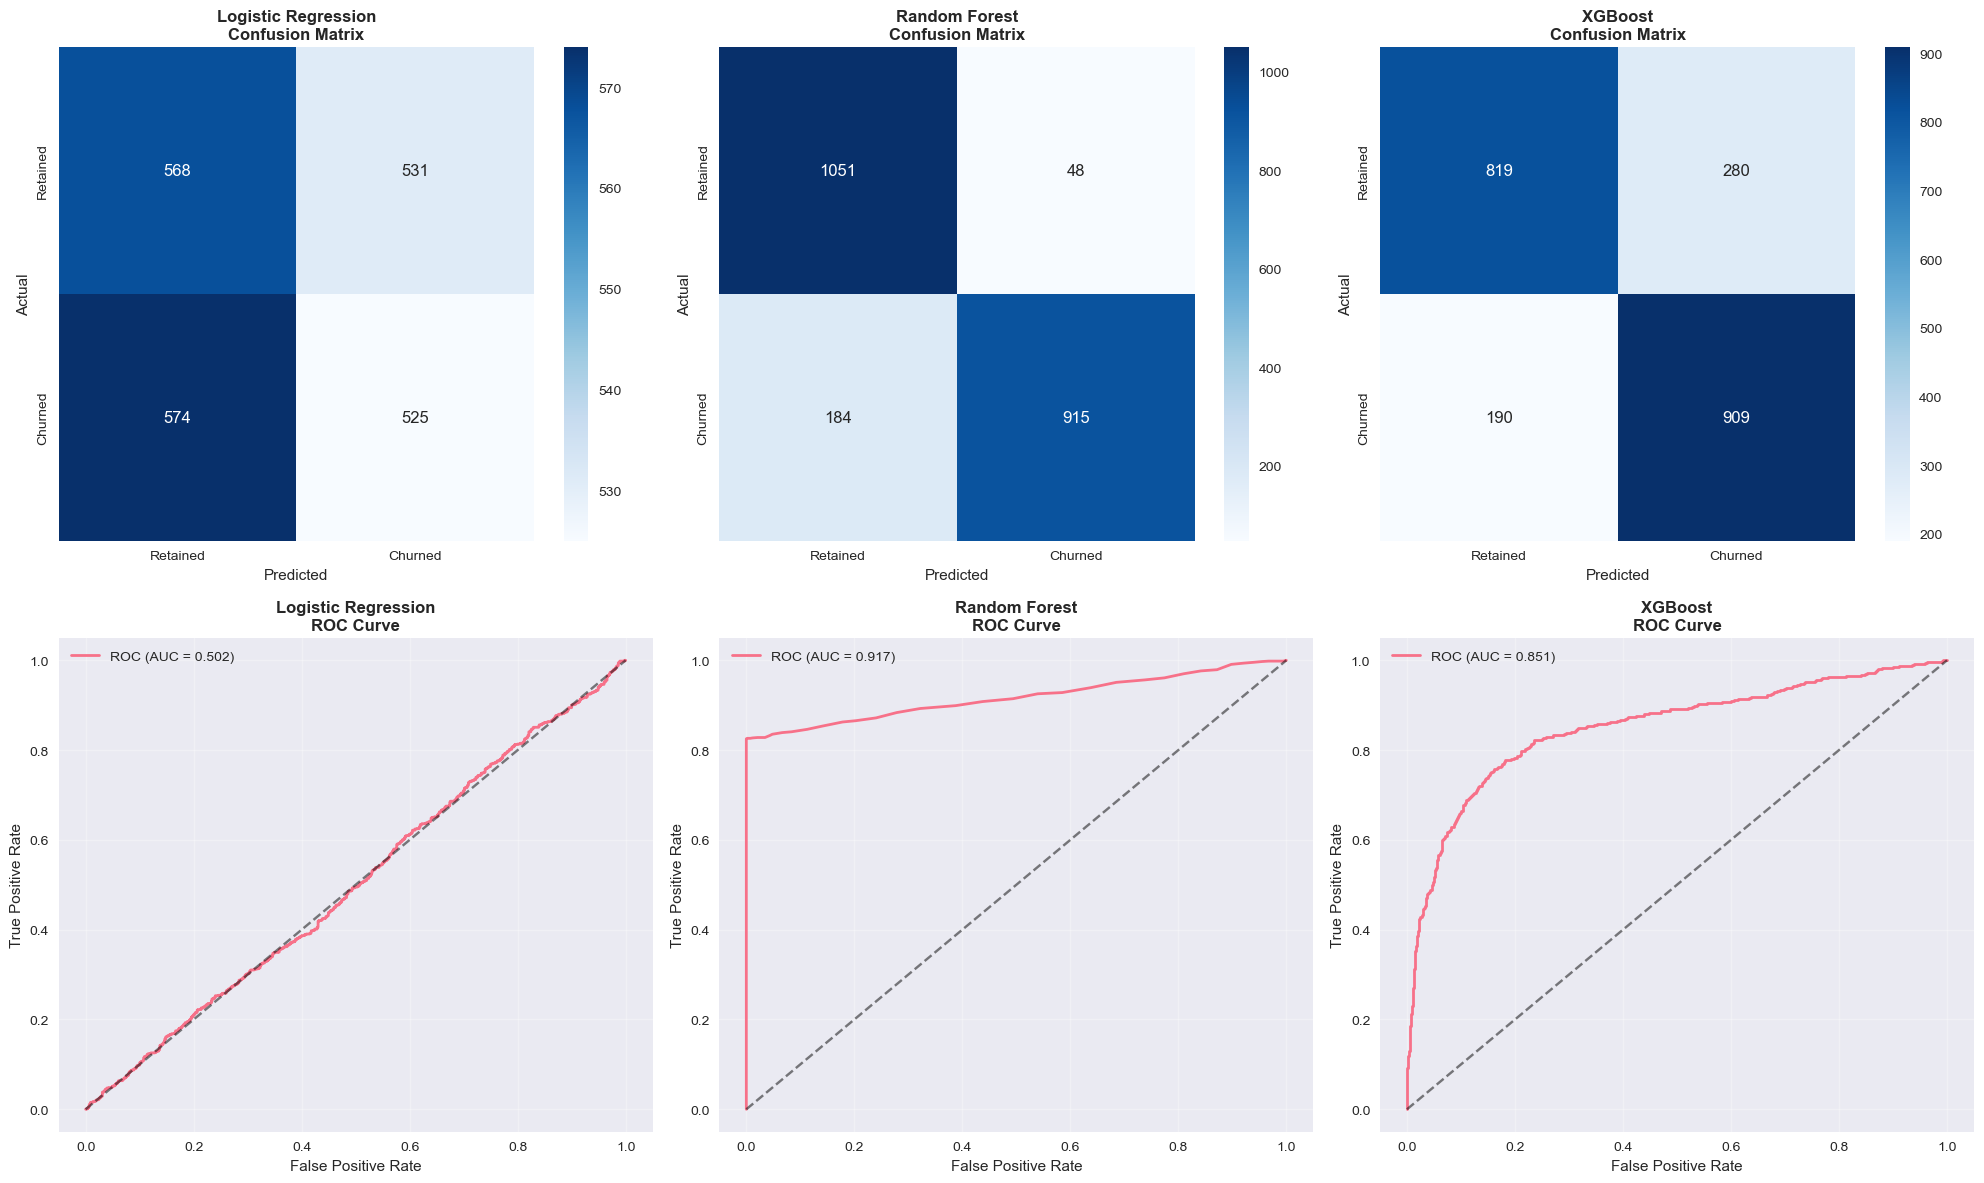

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
model_names = list(model_results.keys())


for idx, name in enumerate(model_names):
    y_pred = model_results[name]['predictions']
    cm = confusion_matrix(y_val, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, idx])
    axes[0, idx].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel('Predicted')
    axes[0, idx].set_ylabel('Actual')
    axes[0, idx].set_xticklabels(['Retained', 'Churned'])
    axes[0, idx].set_yticklabels(['Retained', 'Churned'])


for idx, name in enumerate(model_names):
    y_pred_proba = model_results[name]['probabilities']
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = model_results[name]['roc_auc']
    
    axes[1, idx].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    axes[1, idx].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[1, idx].set_xlabel('False Positive Rate')
    axes[1, idx].set_ylabel('True Positive Rate')
    axes[1, idx].set_title(f'{name}\nROC Curve', fontsize=12, fontweight='bold')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
print("=== HYPERPARAMETER OPTIMIZATION ===")
print(f"Optimizing {best_model_name}...")

best_base_model = trained_models[best_model_name]


if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
else: 
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }


grid_search = GridSearchCV(
    estimator=best_base_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Starting grid search optimization...")
grid_search.fit(X_train, y_train)


print("✅ Hyperparameter optimization completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")


optimized_model = grid_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_val)
y_pred_proba_optimized = optimized_model.predict_proba(X_val)[:, 1]

f1_optimized = f1_score(y_val, y_pred_optimized)
roc_auc_optimized = roc_auc_score(y_val, y_pred_proba_optimized)

print(f"\nOptimized model performance on validation set:")
print(f"F1-Score: {f1_optimized:.4f}")
print(f"ROC-AUC: {roc_auc_optimized:.4f}")

print(f"\nImprovement over base model:")
base_f1 = model_results[best_model_name]['f1_score']
print(f"F1-Score improvement: {f1_optimized - base_f1:.4f}")

=== HYPERPARAMETER OPTIMIZATION ===
Optimizing Random Forest...
Starting grid search optimization...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Hyperparameter optimization completed!
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation F1-score: 0.8440

Optimized model performance on validation set:
F1-Score: 0.8962
ROC-AUC: 0.9129

Improvement over base model:
F1-Score improvement: 0.0087


=== FEATURE IMPORTANCE ANALYSIS ===
Tree-based Feature Importance Rankings:
              Feature  Importance
     Monthly_Spending      0.1212
    Total_Usage_Hours      0.1177
      Streaming_Usage      0.1066
        Discount_Used      0.1050
   Account_Age_Months      0.1004
                  Age      0.0981
        Support_Calls      0.0644
   Satisfaction_Score      0.0638
             Location      0.0457
    Complaint_Tickets      0.0448
        Late_Payments      0.0439
Last_Interaction_Type      0.0305
    Subscription_Type      0.0254
               Gender      0.0183
       Promo_Opted_In      0.0142


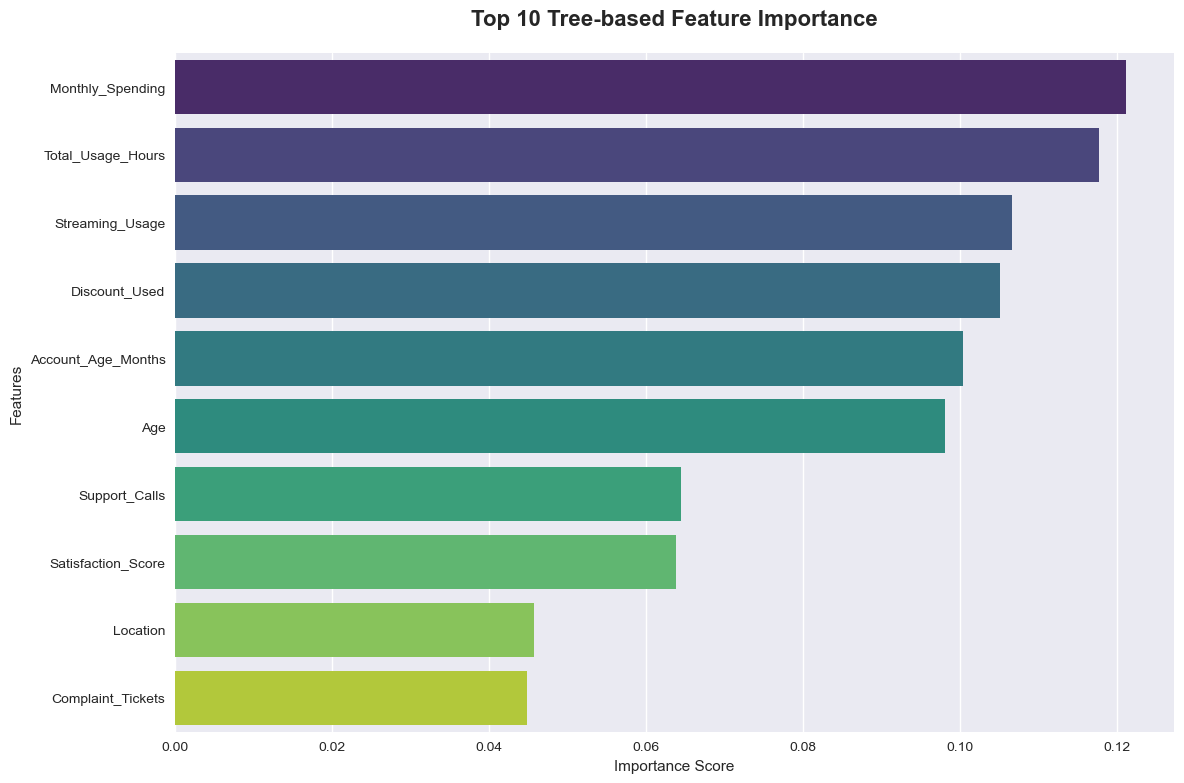


🔍 BUSINESS INSIGHTS:
Top 3 most important features for churn prediction:
6. Monthly_Spending: 0.1212
7. Total_Usage_Hours: 0.1177
10. Streaming_Usage: 0.1066


In [14]:
print("=== FEATURE IMPORTANCE ANALYSIS ===")

if hasattr(optimized_model, 'feature_importances_'):
    feature_importance = optimized_model.feature_importances_
    importance_type = "Tree-based Feature Importance"
elif hasattr(optimized_model, 'coef_'):
    feature_importance = abs(optimized_model.coef_[0])
    importance_type = "Coefficient Magnitude"
else:
    print("Feature importance not available for this model type")
    feature_importance = None

if feature_importance is not None:

    feature_names = X_processed.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print(f"{importance_type} Rankings:")
    print(importance_df.to_string(index=False, float_format='%.4f'))
 
    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
    plt.title(f'Top 10 {importance_type}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
 
    print(f"\n🔍 BUSINESS INSIGHTS:")
    print(f"Top 3 most important features for churn prediction:")
    for i, row in importance_df.head(3).iterrows():
        print(f"{i+1}. {row['Feature']}: {row['Importance']:.4f}")

In [15]:
print("=== TEST DATA PREPROCESSING AND PREDICTION ===")


X_test_processed, _, customer_ids_test, _, _ = preprocess_data(
    test_df, 
    is_training=False, 
    scaler=scaler, 
    encoders=encoders
)

print(f"✅ Test data preprocessed: {X_test_processed.shape}")


print("Generating predictions...")
test_predictions = optimized_model.predict(X_test_processed)
test_probabilities = optimized_model.predict_proba(X_test_processed)[:, 1]

print(f"✅ Predictions generated for {len(test_predictions)} customers")

unique, counts = np.unique(test_predictions, return_counts=True)
print("\nPrediction Distribution:")
for pred, count in zip(unique, counts):
    label = "Churned" if pred == 1 else "Retained"
    percentage = (count / len(test_predictions)) * 100
    print(f"{label} (Class {pred}): {count} customers ({percentage:.2f}%)")

=== TEST DATA PREPROCESSING AND PREDICTION ===
✅ Test data preprocessed: (2000, 15)
Generating predictions...
✅ Predictions generated for 2000 customers

Prediction Distribution:
Retained (Class 0): 1942 customers (97.10%)
Churned (Class 1): 58 customers (2.90%)


In [16]:
print("=== CREATING SUBMISSION FILE ===")


submission_df = pd.DataFrame({
    'Customer_ID': customer_ids_test,
    'Churn': test_predictions
})


print("Submission file preview:")
print(submission_df.head(10))
print(f"\nSubmission shape: {submission_df.shape}")
print(f"Column names: {list(submission_df.columns)}")
print(f"Data types:")
print(submission_df.dtypes)

submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)
print(f"✅ Submission file saved as '{submission_filename}'")


print(f"\nSubmission Validation:")
print(f"✓ Contains {len(submission_df)} predictions")
print(f"✓ Customer_ID range: {submission_df['Customer_ID'].min()} to {submission_df['Customer_ID'].max()}")
print(f"✓ Churn values: {sorted(submission_df['Churn'].unique())}")
print(f"✓ No missing values: {submission_df.isnull().sum().sum() == 0}")

=== CREATING SUBMISSION FILE ===
Submission file preview:
   Customer_ID  Churn
0         9001      0
1         9002      0
2         9003      0
3         9004      0
4         9005      0
5         9006      0
6         9007      0
7         9008      0
8         9009      0
9         9010      0

Submission shape: (2000, 2)
Column names: ['Customer_ID', 'Churn']
Data types:
Customer_ID    int64
Churn          int64
dtype: object
✅ Submission file saved as 'submission.csv'

Submission Validation:
✓ Contains 2000 predictions
✓ Customer_ID range: 9001 to 11000
✓ Churn values: [0, 1]
✓ No missing values: True


In [17]:
print("=== MODEL PERSISTENCE ===")


model_filename = f'best_churn_model_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(optimized_model, model_filename)
print(f"✅ Model saved as '{model_filename}'")


preprocessing_components = {
    'scaler': scaler,
    'encoders': encoders,
    'feature_names': list(X_processed.columns)
}
preprocessing_filename = 'preprocessing_components.pkl'
joblib.dump(preprocessing_components, preprocessing_filename)
print(f"✅ Preprocessing components saved as '{preprocessing_filename}'")


model_metadata = {
    'model_type': best_model_name,
    'best_parameters': grid_search.best_params_,
    'validation_f1_score': f1_optimized,
    'validation_roc_auc': roc_auc_optimized,
    'training_samples': len(X_train),
    'feature_count': len(X_processed.columns),
    'class_distribution': y_train.value_counts().to_dict()
}

metadata_filename = 'model_metadata.pkl'
joblib.dump(model_metadata, metadata_filename)
print(f"✅ Model metadata saved as '{metadata_filename}'")


print("=== FINAL MODEL VALIDATION ===")
cv_scores = cross_val_score(optimized_model, X_processed, y, cv=5, scoring='f1')
print(f"5-Fold Cross-Validation F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


print("\nRetraining on full dataset for deployment...")
final_model = optimized_model.fit(X_processed, y)

print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Model Type: {best_model_name}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Cross-Validation F1-Score: {cv_scores.mean():.4f}")
print(f"Validation F1-Score: {f1_optimized:.4f}")
print(f"Validation ROC-AUC: {roc_auc_optimized:.4f}")
print(f"Training Samples: {len(X_processed):,}")
print(f"Features Used: {len(X_processed.columns)}")
print(f"Test Predictions Generated: {len(test_predictions):,}")


final_model_filename = 'final_churn_prediction_model.pkl'
joblib.dump(final_model, final_model_filename)
print(f"✅ Final model saved as '{final_model_filename}'")

=== MODEL PERSISTENCE ===
✅ Model saved as 'best_churn_model_random_forest.pkl'
✅ Preprocessing components saved as 'preprocessing_components.pkl'
✅ Model metadata saved as 'model_metadata.pkl'
=== FINAL MODEL VALIDATION ===
5-Fold Cross-Validation F1-Scores: [0.89635036 0.89517309 0.8947626  0.90564202 0.89597645]
Mean CV F1-Score: 0.8976 (+/- 0.0081)

Retraining on full dataset for deployment...

FINAL MODEL SUMMARY
Model Type: Random Forest
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Cross-Validation F1-Score: 0.8976
Validation F1-Score: 0.8962
Validation ROC-AUC: 0.9129
Training Samples: 10,990
Features Used: 15
Test Predictions Generated: 2,000
✅ Final model saved as 'final_churn_prediction_model.pkl'
